In [49]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler

In [50]:
from sqlite3 import connect

In [51]:
conn = connect('stocks.db')

In [52]:
df = pd.read_sql('SELECT * FROM alltickers', conn)
df.head()

,ticker,date,open,high,low,close,adjClose,volume,dailyreturn
0,AAPL,2022-09-08,154.640,156.35,152.68,154.46,154.46,83851495,-0.009618
1,AAPL,2022-09-07,154.825,156.67,153.61,155.96,155.96,87450049,0.009254
2,AAPL,2022-09-06,156.470,157.09,153.69,154.53,154.53,73607839,-0.008215
3,AAPL,2022-09-02,159.750,160.36,154.97,155.81,155.81,76910050,-0.013611
4,AAPL,2022-09-01,156.640,158.42,154.67,157.96,157.96,74118439,0.004707


In [53]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [54]:
def load_data(company, start, end):
    dataframe = df.copy()
    dataframe = dataframe.loc[dataframe.ticker == company, :]
    dataframe = dataframe.loc[(dataframe['date'] > start) & (dataframe['date'] < end), :]
    dataframe = dataframe.rename(columns = {'close': 'Close'})
    return dataframe

In [55]:
COMPANY = 'AAPL'
START_DATE = dt.datetime(2018,1,1)
END_DATE = dt.datetime(2022,6,1)
START_DATE_TEST = END_DATE

In [56]:
data = load_data(company = COMPANY,
                 start = START_DATE,
                 end = END_DATE)

In [57]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [58]:
# how many days do i want to base my predictions on ?
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [59]:
def LSTM_model():
    
    #model = Sequential()
    
    #model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    #model.add(Dropout(0.2))

    #model.add(LSTM(units = 50, return_sequences = True))
    #model.add(Dropout(0.2))

    #model.add(LSTM(units = 50))
    #model.add(Dropout(0.2))
    
    #model.add(Dense(units=1))

    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    
    return model

In [60]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam',loss='mean_squared_error')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 128)           66560     
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 25)                1625      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [61]:
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

model.fit(x_train, 
          y_train, 
          epochs=25, 
          batch_size = 32,
          callbacks = [checkpointer])

Epoch 1/25
33/33 [==============================] - 3s 18ms/step - loss: 0.0124
Epoch 2/25
33/33 [==============================] - 0s 12ms/step - loss: 9.2636e-04
Epoch 3/25
33/33 [==============================] - 0s 12ms/step - loss: 7.5427e-04
Epoch 4/25
33/33 [==============================] - 0s 12ms/step - loss: 8.2057e-04
Epoch 5/25
33/33 [==============================] - 0s 12ms/step - loss: 6.3247e-04
Epoch 6/25
33/33 [==============================] - 0s 11ms/step - loss: 6.9363e-04
Epoch 7/25
33/33 [==============================] - 0s 12ms/step - loss: 6.0638e-04
Epoch 8/25
33/33 [==============================] - 0s 12ms/step - loss: 6.0566e-04
Epoch 9/25
33/33 [==============================] - 0s 12ms/step - loss: 5.6095e-04
Epoch 10/25
33/33 [==============================] - 0s 11ms/step - loss: 5.9398e-04
Epoch 11/25
33/33 [==============================] - 0s 12ms/step - loss: 5.8996e-04
Epoch 12/25
33/33 [==============================] - 0s 11ms/step - loss: 5.43

In [62]:
def draw_stock_trade(COMPANY):
    test_data = load_data(company = COMPANY,
                      start = START_DATE_TEST,
                      end = dt.datetime.now())

    actual_prices = test_data['Close'].values

    total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

    model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
    model_inputs = model_inputs.reshape(-1,1)
    model_inputs = scaler.transform(model_inputs)
    x_test = []
    for x in range(prediction_days, len(model_inputs)):
        x_test.append(model_inputs[x-prediction_days:x, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

    predicted_prices = model.predict(x_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)

    plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
    plt.plot(predicted_prices, color= 'green', label=f"predicted {COMPANY} price")
    plt.title(f"{COMPANY} share price")
    plt.xlabel("time")
    plt.ylabel(f"{COMPANY} share price")
    plt.legend()
    plt.show()

C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2538927029.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 1s 11ms/step


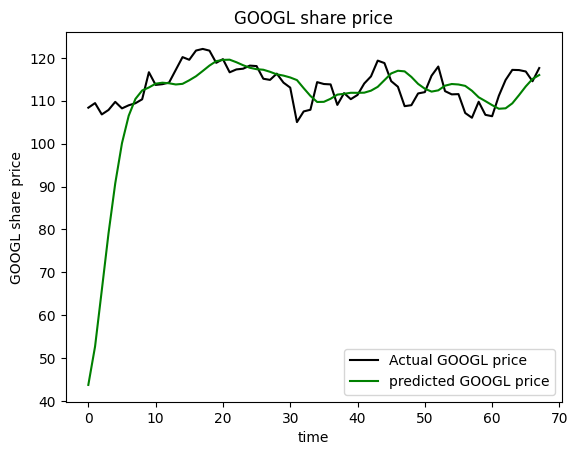

In [63]:
draw_stock_trade("GOOGL")

4/4 [==============================] - 0s 15ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2538927029.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


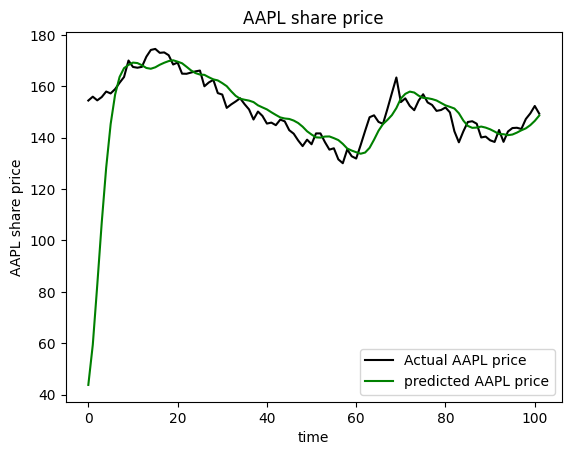

In [64]:
draw_stock_trade("AAPL")

3/3 [==============================] - 0s 18ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2538927029.py:10: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


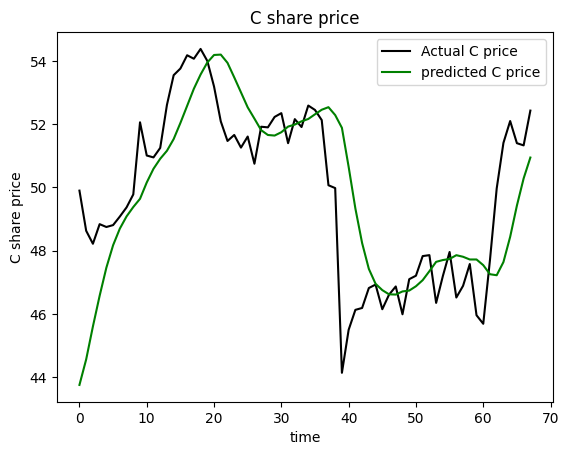

In [65]:
draw_stock_trade("C")

In [66]:
def get_stock_data(COMPANY):
    test_data = load_data(company = COMPANY,
                      start = START_DATE_TEST,
                      end = dt.datetime.now())
    actual_prices = test_data['Close'].values

    total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

    model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
    model_inputs = model_inputs.reshape(-1,1)
    model_inputs = scaler.transform(model_inputs)
    x_test = []
    for x in range(prediction_days, len(model_inputs)):
        x_test.append(model_inputs[x-prediction_days:x, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

    predicted_prices = model.predict(x_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)
    dateList = test_data['date'].values
    res = []
    for i in range(len(dateList)):
        temp = [COMPANY, dateList[i], predicted_prices[i], actual_prices[i]]
        res.append(temp)
    return res

In [67]:
test = get_stock_data("AAPL")

4/4 [==============================] - 0s 18ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


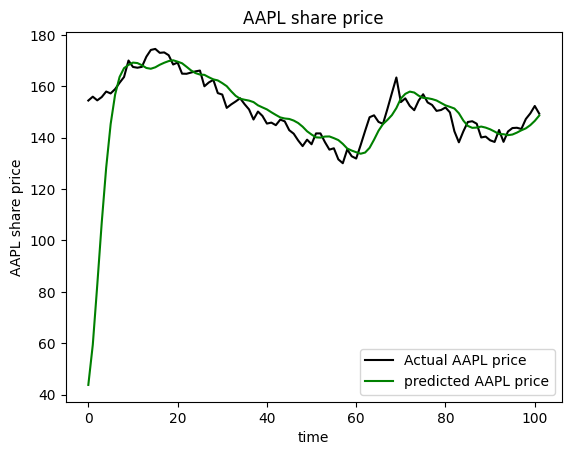

In [68]:

plt.plot([t[3] for t in test], color='black', label=f"Actual {COMPANY} price")
plt.plot([t[2] for t in test], color= 'green', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

In [69]:
companyList = df['ticker'].unique()

In [70]:
companyList

array(['AAPL', 'MSFT', 'AMZN', 'TSLA', 'GOOGL', 'GOOG', 'BRK.B', 'UNH',
       'JNJ', 'XOM', 'PG', 'META', 'JPM', 'NVDA', 'V', 'HD', 'CVX',
       'ABBV', 'MA', 'PFE', 'LLY', 'PEP', 'KO', 'BAC', 'MRK', 'COST',
       'TMO', 'AVGO', 'WMT', 'DIS', 'MCD', 'ABT', 'DHR', 'CSCO', 'VZ',
       'ACN', 'NEE', 'WFC', 'BMY', 'TXN', 'CRM', 'PM', 'CMCSA', 'QCOM',
       'LIN', 'ADBE', 'CVS', 'COP', 'UNP', 'NKE', 'AMGN', 'RTX', 'UPS',
       'LOW', 'HON', 'T', 'INTC', 'INTU', 'IBM', 'MDT', 'AMD', 'ELV',
       'MS', 'SPGI', 'SCHW', 'AMT', 'GS', 'PYPL', 'NFLX', 'ORCL', 'LMT',
       'SBUX', 'ADP', 'DE', 'BLK', 'CAT', 'C', 'CI', 'AXP', 'MDLZ', 'PLD',
       'SO', 'TMUS', 'DUK', 'GILD', 'NOW', 'MMC', 'CB', 'REGN', 'MO',
       'ADI', 'AMAT', 'BA', 'VRTX', 'TJX', 'PGR', 'TGT', 'GE', 'ZTS',
       'NOC', 'SYK', 'ISRG', 'BDX', 'BRK-B'], dtype=object)

In [71]:
def get_all_stock_data(companyList):
    res = []
    for company in companyList:
        res += get_stock_data(company)
    return res

In [72]:
conn.close()

In [73]:
temp = get_all_stock_data(companyList)

1/4 [======>.......................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


1/4 [======>.......................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


1/4 [======>.......................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


4/4 [==============================] - 0s 7ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


4/4 [==============================] - 0s 8ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


4/4 [==============================] - 0s 8ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


4/4 [==============================] - 0s 8ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


4/4 [==============================] - 0s 8ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 9ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


4/4 [==============================] - 0s 9ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


1/4 [======>.......................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 8ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 10ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 8ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 9ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 8ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 10ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 8ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 8ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 17ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 16ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


1/3 [=========>....................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 10ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 10ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 10ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 13ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 16ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 17ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 13ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 10ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 10ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 16ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 16ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


1/3 [=========>....................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 20ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


1/3 [=========>....................] - ETA: 0s

C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 7ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureW

3/3 [==============================] - 0s 7ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 8ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 7ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 7ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 7ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 10ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 10ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 16ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 15ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 8ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 14ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 12ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 9ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


3/3 [==============================] - 0s 13ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


2/2 [==============================] - 0s 8ms/step


C:\Users\wangz\AppData\Local\Temp\ipykernel_19224\2529516299.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values


In [74]:
temp = [[t[0],pd.to_datetime(str(t[1])).strftime('%Y-%m-%d'),t[2][0],t[3]] for t in temp]

In [75]:
print(temp)

[['AAPL', '2022-09-08', 43.756905, 154.46], ['AAPL', '2022-09-07', 59.3799, 155.96], ['AAPL', '2022-09-06', 82.60548, 154.53], ['AAPL', '2022-09-02', 106.8501, 155.81], ['AAPL', '2022-09-01', 128.32564, 157.96], ['AAPL', '2022-08-31', 145.28441, 157.22], ['AAPL', '2022-08-30', 156.7897, 158.91], ['AAPL', '2022-08-29', 163.62512, 161.38], ['AAPL', '2022-08-26', 167.06572, 163.62], ['AAPL', '2022-08-25', 168.3368, 170.03], ['AAPL', '2022-08-24', 169.22412, 167.53], ['AAPL', '2022-08-23', 169.0425, 167.23], ['AAPL', '2022-08-22', 168.20168, 167.57], ['AAPL', '2022-08-19', 167.1348, 171.52], ['AAPL', '2022-08-18', 166.83348, 174.15], ['AAPL', '2022-08-17', 167.39444, 174.55], ['AAPL', '2022-08-16', 168.37923, 173.03], ['AAPL', '2022-08-15', 169.16904, 173.19], ['AAPL', '2022-08-12', 169.81667, 172.1], ['AAPL', '2022-08-11', 170.12645, 168.49], ['AAPL', '2022-08-10', 169.59105, 169.24], ['AAPL', '2022-08-09', 168.95993, 164.92], ['AAPL', '2022-08-08', 167.60387, 164.87], ['AAPL', '2022-08-0

In [76]:
df = pd.DataFrame(temp, columns= ['ticker','date','predict','actual'])

In [77]:

conn = connect('new_lstm_prediction.db')
df.to_sql('predictions', conn, if_exists='replace', index = False)

7683